# Imports and DB connection
This file is for discovery 

In [342]:
import sqlite3
import pandas as pd
import numpy as np
import ast

In [343]:
con = sqlite3.connect('./cademycode.db')

In [344]:
curs = con.cursor()

# Find Table Names

In [345]:
tables = curs.execute("""
SELECT name FROM sqlite_master
WHERE type='table';""").fetchall()

In [346]:
print(tables)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


- Here we see that the name of our tables are:
1. cademycode_students
2. cademycode_courses
3. cademycode_student_jobs
 
# Get the Tables as DFs

In [347]:
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
courses = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

In [348]:
print('Students: ' + str(len(students)))
print('Courses: ' + str(len(courses)))
print('Student Jobs: ' + str(len(student_jobs)))

Students: 5000
Courses: 10
Student Jobs: 13


- Above we see the lengths of each DF (ie. entries in the tables)

# Cleaning
# students Table

In [349]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


In [350]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


Notes on students table:
- 5000 entries
- Have missing data in job_id, num_course_taken, current_career_path_id, and time_spent_hrs columns
- contact_info is a dictionary (should explore and separate into columns)
- UUID corresponds to students
- dob = date of birth, will change to datetime (could utilize age)
- all data types (aside from uuid) are objects, will change numerical columns to float/int

# Fix Column Datatypes
time_spent_hours should be float, num_course_taken should be int, job_id and current_career_path_id are categorical. A lot of these columns have missing data, so we will make them all floats for now

In [351]:
students['job_id'] = students['job_id'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float)
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)

In [352]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   contact_info            5000 non-null   object 
 5   job_id                  4995 non-null   float64
 6   num_course_taken        4749 non-null   float64
 7   current_career_path_id  4529 non-null   float64
 8   time_spent_hrs          4529 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 351.7+ KB


# DOB to Age
- add an age column and use DOB to calculate age

In [353]:
now = pd.to_datetime('today')
students['age'] = (now - pd.to_datetime(students['dob'])).astype('<m8[Y]')
students['age_group'] = np.int64((students['age']/10))*10

In [354]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,79.0,70
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.40,32.0,30
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,33.0,30
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,34.0,30
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,59.0,50


# contact_info 
- This column appears to be saved as an object (string)
- We should convert it to a dictionary and then explode the dictionary to get seperate columns for mailing address and email address

In [355]:
students['contact_info'] = students["contact_info"].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis=1), explode_contact], axis=1)

In [356]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,79.0,70,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.40,32.0,30,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,30,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,34.0,30,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,59.0,50,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


- may be beneficial to split mailing address up further to street, city, state, zip

In [357]:
split_mailing = students.mailing_address.str.split(',', expand=True)
split_mailing.columns = ['street', 'city', 'state', 'zip_code']
students = pd.concat([students.drop('mailing_address', axis=1), split_mailing], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,79.0,70,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.40,32.0,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,34.0,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,59.0,50,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


In [358]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   job_id                  4995 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4529 non-null   float64
 7   time_spent_hrs          4529 non-null   float64
 8   age                     5000 non-null   float64
 9   age_group               5000 non-null   int64  
 10  email                   5000 non-null   object 
 11  street                  5000 non-null   object 
 12  city                    5000 non-null   object 
 13  state                   5000 non-null   object 
 14  zip_code                5000 non-null   

# Missing Data
> num_course_taken 

What is the nature of the missing data? Is it structurally missing, MAR, or MNAR?


In [359]:
missing_course_taken = students[students[['num_course_taken']].isnull().any(axis=1)]
display(missing_course_taken)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,52.0,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,69.0,60,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,45.0,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,61.0,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,38.0,30,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4889,4890,Tegan Cochran,1970-11-08,F,5.0,NaN,8.0,22.75,52.0,50,tegan130@inlook.com,106 Sunny Nook,Vernal,Georgia,10769
4898,4899,Ruthann Oliver,1998-05-22,F,3.0,NaN,7.0,21.27,24.0,20,ruthann1124@woohoo.com,644 Merry Island,Green Valley,Wyoming,91273
4914,4915,Ernest Holmes,1995-03-11,M,7.0,NaN,9.0,26.50,28.0,20,ernest_holmes505@hmail.com,872 Wintergreen Harbor,Gallitzin borough,Maine,50103
4980,4981,Brice Franklin,1946-12-01,M,4.0,NaN,5.0,8.66,76.0,70,brice9741@coldmail.com,947 Panda Way,New Bedford village,Vermont,31232


- Examine graphs to see if there is a noticeable pattern for the missing data

<Axes: xlabel='sex'>

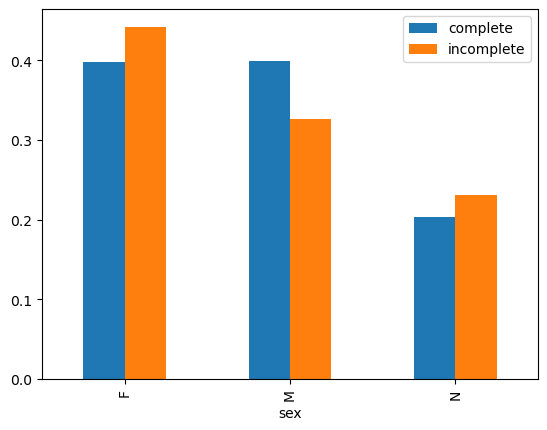

In [360]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('sex').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

<Axes: xlabel='job_id'>

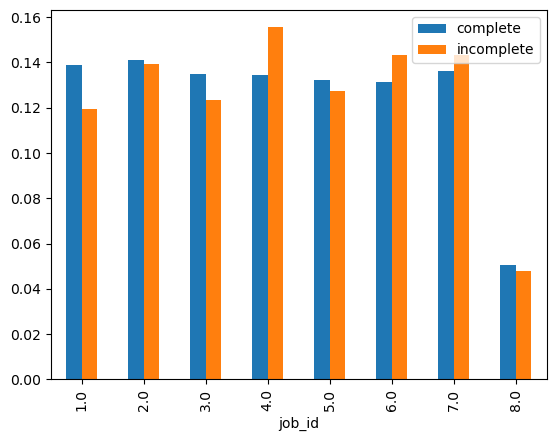

In [361]:
sg = (students.groupby('job_id').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('job_id').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

<Axes: xlabel='age_group'>

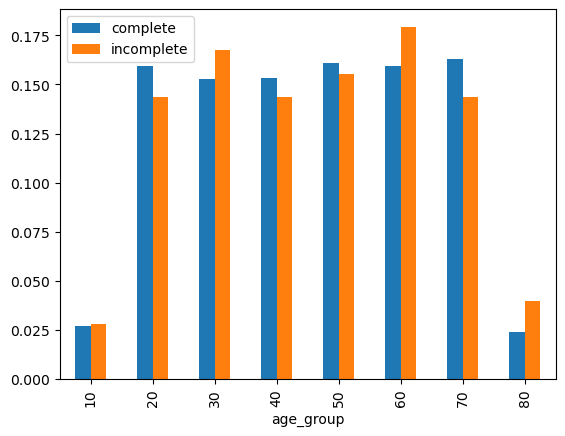

In [362]:
sg = (students.groupby('age_group').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('age_group').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

- I don't see any noticeable reasons for the missing data as nothing about the above graphs (students grouped by sex, job_id, age compared with the missing data) jumps out. I would argue that this data is MAR.  Because a low percentage of the data is missing and we have labeled it as MAR, I will delete it from the dataset
    - I will save the data in the event someone wants to investiage further

In [363]:
missing_data = pd.DataFrame()
missing_data = pd.concat([missing_data, missing_course_taken])
students = students.dropna(subset=['num_course_taken'])

In [364]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4749 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4749 non-null   int64  
 1   name                    4749 non-null   object 
 2   dob                     4749 non-null   object 
 3   sex                     4749 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4298 non-null   float64
 7   time_spent_hrs          4298 non-null   float64
 8   age                     4749 non-null   float64
 9   age_group               4749 non-null   int64  
 10  email                   4749 non-null   object 
 11  street                  4749 non-null   object 
 12  city                    4749 non-null   object 
 13  state                   4749 non-null   object 
 14  zip_code                4749 non-null   

> job_id column

In [365]:
missing_job_id = students[students[['job_id']].isnull().any(axis=1)]
display(missing_job_id)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,20.0,20,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,21.0,20,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,20.0,20,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,21.0,20,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,20.0,20,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


- There are only 5 missing rows of data and, with no pattern recognizable, I am going to remove this data

In [366]:
missing_data = pd.concat([missing_data, missing_job_id])
students = students.dropna(subset=['job_id'])
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4293 non-null   float64
 7   time_spent_hrs          4293 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

> current_career_path_id

In [367]:
missing_path = students[students[['current_career_path_id']].isnull().any(axis=1)]
display(missing_path)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,47.0,40,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,33.0,30,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,33.0,30,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,26.0,20,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,67.0,60,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,4905,Eduardo Daniel,2004-06-18,M,8.0,12.0,NaN,NaN,18.0,10,daniel5073@inlook.com,598 Deer Trace,Forest Grove,North Carolina,45038
4922,4923,Francisco van Ede,1961-04-26,M,7.0,5.0,NaN,NaN,62.0,60,vanede7845@coldmail.com,282 Fourth Trace,Carter Lake,Ohio,63511
4948,4949,Dewitt van Malsem,1949-03-08,M,4.0,7.0,NaN,NaN,74.0,70,dewitt4635@inlook.com,423 Course Trail,Wilmot,Hawaii,18996
4956,4957,Todd Stamhuis,1961-06-15,M,7.0,8.0,NaN,NaN,61.0,60,todd8019@woohoo.com,251 Grand Rose Underpass,Niagara,Pennsylvania,03430


- It looks like time_spent_hrs is also missing when current_career_path_id is missing, let's check

In [368]:
missing_path.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 15 to 4974
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    451 non-null    int64  
 1   name                    451 non-null    object 
 2   dob                     451 non-null    object 
 3   sex                     451 non-null    object 
 4   job_id                  451 non-null    float64
 5   num_course_taken        451 non-null    float64
 6   current_career_path_id  0 non-null      float64
 7   time_spent_hrs          0 non-null      float64
 8   age                     451 non-null    float64
 9   age_group               451 non-null    int64  
 10  email                   451 non-null    object 
 11  street                  451 non-null    object 
 12  city                    451 non-null    object 
 13  state                   451 non-null    object 
 14  zip_code                451 non-null    

- That is in fact the case, current_career_path_id and time_spent_hrs are simultaneously missing, leading me to believe that these columns are structurally missing.
- **Solution: add an id that corresponds to "no current career path" and will equal 0 and set time_spent_hrs to 0 for those rows as well**

In [369]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [370]:
students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])

In [371]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

- **We have now taken care of all of our missing data!**

In [372]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

**We now have a healthy students DataFrame that has no missing/null values and we can move on**

# student_jobs table

In [373]:
student_jobs.head()

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000


In [374]:
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [375]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 440.0+ bytes


Notes on student_jobs table:
- We have some duplicates (based on the job_id column) that need to be handled

In [376]:
student_jobs.drop_duplicates(inplace=True)
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


# courses table

In [377]:
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [378]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


Notes on courses table:
- Nothing appears to need cleansing
- We should add our career_path_id of 0 that we added in to our students table to keep everything consistent

In [379]:
none = {
    'career_path_id': 0,
    'career_path_name': 'none',
    'hours_to_complete': 0}

courses.loc[len(courses)] = none
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


# Join Tables
- Convert ids to integers 
- Join tables

In [382]:
students['job_id'] = students['job_id'].astype(int)
students['current_career_path_id'] = students['current_career_path_id'].astype(int)
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int32  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int32  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

In [383]:
joined_df = students.merge(courses, left_on='current_career_path_id', right_on='career_path_id', how='left')
joined_df = joined_df.merge(student_jobs, on='job_id', how='left')
joined_df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7,6.0,1,4.99,79.0,70,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7,5.0,8,4.40,32.0,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7,8.0,8,6.74,33.0,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6,7.0,9,12.31,34.0,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7,14.0,3,5.64,59.0,50,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


In [384]:
joined_df.info()
con.close()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int32  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int32  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

# Create output CSV
- Create clean SQL database file
- Generate CSV file from that database
- Also add missing data to a table for analytics team to review (if they choose to)

In [385]:
connection = sqlite3.connect('cademycode_cleansed.db')
joined_df.to_sql('cademycode_cleansed', connection, if_exists='replace', index=False)

4744

In [386]:
db_df = pd.read_sql_query("SELECT * FROM cademycode_cleansed", connection)

In [387]:
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int64  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int64  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

In [388]:
missing_data.to_sql('missing_data', connection, if_exists='replace', index=False)

256

In [389]:
missing_df = pd.read_sql_query("SELECT * FROM missing_data", connection)
connection.close()

In [390]:
db_df.to_csv('cademycode_cleansed.csv')